# Assignment 2: Group Project
## Research Methodology – MSc Finance

Subject : *Volatility Modeling: study volatility dynamics of an asset class (e.g., GARCH- type models, realized volatility measures). Analyze volatility predictability and risk management applications.*


In [5]:
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from statsmodels.graphics import tsaplots
import arch as ar

In [6]:
# Stock prices: adjusted close prices of S&P 500 index, from 30 Dec. 1927 to 12 Dec. 2023: sp500.csv.
raw = pd.read_csv('sp500.csv', skiprows=3, # skip metadata in the first 3 lines of the file
                  delimiter=',', index_col=0, parse_dates=[0], dayfirst=False)

sp500 = raw['Adj Close']

sp500

Date
1927-12-30      17.660000
1928-01-03      17.760000
1928-01-04      17.719999
1928-01-05      17.549999
1928-01-06      17.660000
                 ...     
2023-12-06    4549.339844
2023-12-07    4585.589844
2023-12-08    4604.370117
2023-12-11    4622.439941
2023-12-12    4615.609863
Name: Adj Close, Length: 24103, dtype: float64

In [7]:
#Let's compute the log returns
r = np.log(sp500 / sp500.shift())[1:]

## 1. GARCH Model

In the GARCH(1, 1) model, the log return from $t-1$ to $t$ is given by

$$
r_t=\mu+\varepsilon_t,
$$

where:

- $\varepsilon_t$ has mean 0 and variance $\sigma_{t-1}^2$ conditional on the information set (sigma-field) $F_{t-1}=\sigma(r_s,\sigma_s;0\leq s\leq t-1)$;
- we have, for all $t\geq1$,

$$
\sigma_t^2=\omega+\alpha\varepsilon_t^2+\beta\sigma_{t-1}^2.
$$


In [8]:
# For this model we'll have to rescale the value by multiplying it by 100
r100 = 100 * r

garch_model = ar.arch_model(r100, p = 1, q = 1,
                            mean = 'constant', vol = 'GARCH', dist = 'normal')
res = garch_model.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 2.6520197852822972e+16
Iteration:      2,   Func. Count:     16,   Neg. LLF: 76652069.16379625
Iteration:      3,   Func. Count:     23,   Neg. LLF: 43623.955601923655
Iteration:      4,   Func. Count:     30,   Neg. LLF: 32332.619021307495
Iteration:      5,   Func. Count:     36,   Neg. LLF: 32257.915481984608
Iteration:      6,   Func. Count:     42,   Neg. LLF: 31996.280415330617
Iteration:      7,   Func. Count:     47,   Neg. LLF: 32071.01300546652
Iteration:      8,   Func. Count:     53,   Neg. LLF: 53580.9858338302
Iteration:      9,   Func. Count:     60,   Neg. LLF: 31990.845470517357
Iteration:     10,   Func. Count:     65,   Neg. LLF: 31990.770402419268
Iteration:     11,   Func. Count:     70,   Neg. LLF: 31990.769632987856
Iteration:     12,   Func. Count:     75,   Neg. LLF: 31990.76954766915
Iteration:     13,   Func. Count:     80,   Neg. LLF: 31990.76954608223
Iteration:     14,   Func. Count:     84,   Neg. LLF:

The conditional volatilities estimated by `fit` are found in the attribute `conditional_volatility` of the object `res` returned by `fit`:

In [9]:
#The estimated
res.conditional_volatility

Date
1928-01-03    0.738547
1928-01-04    0.725554
1928-01-05    0.700546
1928-01-06    0.743017
1928-01-09    0.734034
                ...   
2023-12-06    0.654308
2023-12-07    0.643553
2023-12-08    0.660939
2023-12-11    0.644640
2023-12-12    0.628719
Name: cond_vol, Length: 24102, dtype: float64

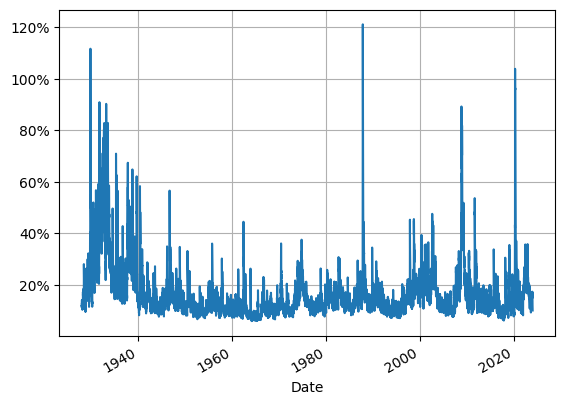

In [10]:
#Annualized vol
garch_vol = np.sqrt(260) * res.conditional_volatility

# Plot
ax = garch_vol.plot()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100, decimals=0))
plt.grid(visible=True);

We are going the compure the actual vol with the estimated garch vol.

In [11]:
def annualized_volatility(val: pd.DataFrame,
                          periods_in_year: int):
    """
    Annualized volatility of logarithmic returns.
    """
    log_ret = np.log(val).diff()
    return log_ret.std() * np.sqrt(periods_in_year)
rw_vol = sp500.rolling(window=20).apply(annualized_volatility, args=(260,))

In [12]:
#Concat vol results
vol = (pd.concat((rw_vol, garch_vol / 100), axis=1)  # Concatenate by rows (horizontally)
      .set_axis(('Rolling', 'GARCH'), axis=1)  # Change column names for readibility
      )

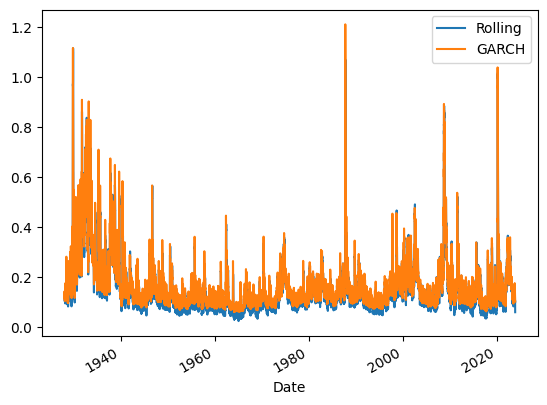

In [13]:
ax = vol.plot()